In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier



In [34]:
cleaned = 1
if cleaned:
    reviews = pd.read_csv('reviews_1k_cleaned.csv', delimiter=";")
else:
    reviews = pd.read_csv('reviews_1k.csv', delimiter=";")
reviews.head()

,Unnamed: 0,game_name,review_text,hours_played,rating,found_helpful,product_count,review_date,early_access,review_length
0,0,For The Warp,good game i feel the graphics vibe of into the...,10.9,1.0,0.0,127.0,"12 September, 2021",True,441
1,1,For The Warp,brilliant little game had so much fun with it ...,6.1,1.0,0.0,117.0,"19 July, 2021",True,109
2,2,For The Warp,solid deck building space exploration/combat a...,7.7,1.0,0.0,42.0,"22 January, 2021",True,63
3,3,For The Warp,often absolutely dependent on luck in the firs...,14.3,1.0,0.0,212.0,"05 April, 2020",True,277
4,4,For The Warp,a nice game which lacks some polish at the mom...,5.7,1.0,0.0,1289.0,"23 August, 2020",True,466


In [35]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     3832 non-null   int64  
 1   game_name      3832 non-null   object 
 2   review_text    3832 non-null   object 
 3   hours_played   3832 non-null   float64
 4   rating         3832 non-null   float64
 5   found_helpful  3832 non-null   float64
 6   product_count  3832 non-null   float64
 7   review_date    3832 non-null   object 
 8   early_access   3832 non-null   bool   
 9   review_length  3832 non-null   int64  
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 273.3+ KB


In [36]:

if(cleaned):
    sorted_by_review_length = reviews.sort_values('review_length', axis=0)
    sorted_by_review_length.head()

#I would still keep short reviews because "good" indicates positive sentiment already


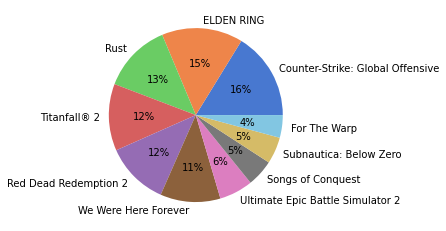

In [37]:
unique_games = reviews.game_name.unique()
colors = sns.color_palette('muted', n_colors=10, as_cmap=True)
game_dist = reviews.game_name.value_counts()
labels = game_dist.index.tolist()
plt.pie(game_dist, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()


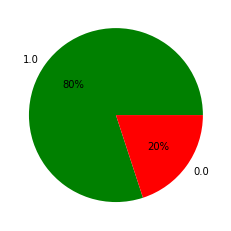

In [38]:
ratings_dist = reviews.rating.value_counts()
labels = ratings_dist.index.tolist()
plt.pie(ratings_dist, labels=labels, colors = ["green", "red"], autopct = '%0.0f%%')
plt.show()

<AxesSubplot:xlabel='game_name'>

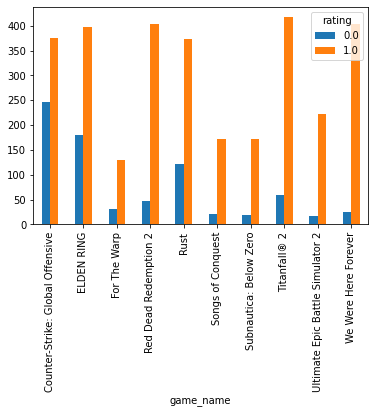

In [39]:
ratings = reviews.groupby(['game_name', 'rating']).rating.count().unstack()
ratings.plot(kind='bar')

In [40]:
#reviews.drop(reviews[reviews.review_length < 20].index, inplace=True)


X = reviews.drop('rating', axis=1)
y = reviews.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((2567, 9), (2567,), (1265, 9), (1265,))

In [41]:
# Unigram Counts

X_train_texts = X_train.review_text

unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(X_train_texts)
X_train_unigram = unigram_vectorizer.transform(X_train_texts)


# Unigram Tf-Idf

unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)


# Bigram Counts

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(X_train_texts)
X_train_bigram = bigram_vectorizer.transform(X_train_texts)


# Bigram Tf-Idf

bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)


In [42]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.8, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nSGDClassifier: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')

    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'XGBoostClassifier: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'MultinomialNB: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
SGDClassifier: Train score: 0.99 ; Validation score: 0.82
XGBoostClassifier: Train score: 0.94 ; Validation score: 0.82
MultinomialNB: Train score: 0.93 ; Validation score: 0.82

Unigram Tf-Idf
SGDClassifier: Train score: 0.99 ; Validation score: 0.85
XGBoostClassifier: Train score: 0.95 ; Validation score: 0.84
MultinomialNB: Train score: 0.81 ; Validation score: 0.81

Bigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.82
XGBoostClassifier: Train score: 0.94 ; Validation score: 0.83
MultinomialNB: Train score: 0.96 ; Validation score: 0.81

Bigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.86
XGBoostClassifier: Train score: 0.95 ; Validation score: 0.84
MultinomialNB: Train score: 0.81 ; Validation score: 0.8



In [43]:
x_train_transformed = X_train_bigram_tf_idf #this had the best validation score (88%)
clf = SGDClassifier()

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4),
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50,
    n_jobs = -1,
)
random_search_cv.fit(x_train_transformed, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 4.305180611967555e-05, 'eta0': 0.005274752169027438, 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'l1'}
Best score: 0.8465143619966475


In [44]:
sgd_classifier = random_search_cv.best_estimator_

#Best params: {'alpha': 9.232722822313204e-05, 'eta0': 0.006418957642841877, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'penalty': 'l2'}
sgd_classifier = SGDClassifier(alpha=9.232722822313204e-05, eta0=0.006418957642841877, learning_rate='adaptive', loss='squared_hinge', penalty='l2')
sgd_classifier.fit(x_train_transformed, y_train)

#transform test data
x_test_transformed = bigram_vectorizer.transform(X_test.review_text)
x_test_transformed = bigram_tf_idf_transformer.transform(x_test_transformed)

#test score
score = sgd_classifier.score(x_test_transformed, y_test)
print("Test score SGD: ", score)




# try MultinomialNB

# Vectorize text reviews to numbers
vec = CountVectorizer(ngram_range=(1, 1))
x_train = vec.fit_transform(X_train_texts).toarray()
x_test = vec.transform(X_test.review_text).toarray()

model = MultinomialNB()
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
print("Test score MultinomialNB: ", score)




Test score SGD:  0.8648221343873518
Test score MultinomialNB:  0.8434782608695652


In [45]:

clf = XGBClassifier()
clf.fit(x_train_transformed, y_train)
score = clf.score(x_test_transformed, y_test)
print("Test score XGB: ", score)


Test score XGB:  0.8521739130434782


In [46]:
'''
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    cv=5,
    n_iter=5
)
random_search_cv.fit(x_train_transformed, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

xgb_classifier = random_search_cv.best_estimator_

#test score
score = xgb_classifier.score(x_test_transformed, y_test)
print(score)
'''

"\nparams = {\n 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],\n 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],\n 'min_child_weight' : [ 1, 3, 5, 7 ],\n 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],\n 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]\n}\n\nrandom_search_cv = RandomizedSearchCV(\n    estimator=clf,\n    param_distributions=params,\n    cv=5,\n    n_iter=5\n)\nrandom_search_cv.fit(x_train_transformed, y_train)\nprint(f'Best params: {random_search_cv.best_params_}')\nprint(f'Best score: {random_search_cv.best_score_}')\n\nxgb_classifier = random_search_cv.best_estimator_\n\n#test score\nscore = xgb_classifier.score(x_test_transformed, y_test)\nprint(score)\n"

Confusion Matrix
[[123 132]
 [ 39 971]]


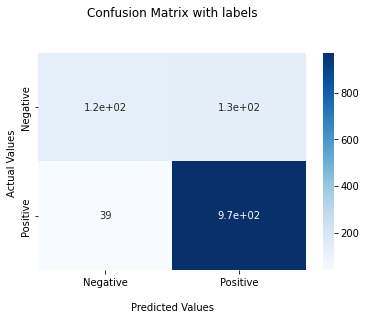


Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.48      0.59       255
         1.0       0.88      0.96      0.92      1010

    accuracy                           0.86      1265
   macro avg       0.82      0.72      0.75      1265
weighted avg       0.86      0.86      0.85      1265



In [47]:
y_pred = sgd_classifier.predict(x_test_transformed)

print("Confusion Matrix")
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Classification Report
print("\nClassification Report")
report = classification_report(y_test, y_pred)
print(report)


In [48]:
#let's see if there's games that get mispredicted more or less often
games = reviews.game_name
X_test.shape, y_pred.shape, y_test.shape

game_names = []
y_pred_list = []
y_true_list = []

for x, y_predictions, y_true in zip(X_test.game_name, y_pred, y_test):
    if(y_predictions != y_true):
        game_names.append(x)
        y_pred_list.append(y_predictions)
        y_true_list.append(y_true)

d = {'game_name': game_names, 'prediction': y_pred_list, 'true': y_true_list}
false_preds = pd.DataFrame(data=d)

false_preds.head()


,game_name,prediction,true
0,We Were Here Forever,0.0,1.0
1,Counter-Strike: Global Offensive,1.0,0.0
2,Subnautica: Below Zero,1.0,0.0
3,Counter-Strike: Global Offensive,1.0,0.0
4,Titanfall® 2,1.0,0.0


Counter-Strike: Global Offensive    62
ELDEN RING                          42
Rust                                28
Titanfall® 2                         9
For The Warp                         8
Songs of Conquest                    7
Ultimate Epic Battle Simulator 2     6
Subnautica: Below Zero               4
Red Dead Redemption 2                3
We Were Here Forever                 2
Name: game_name, dtype: int64


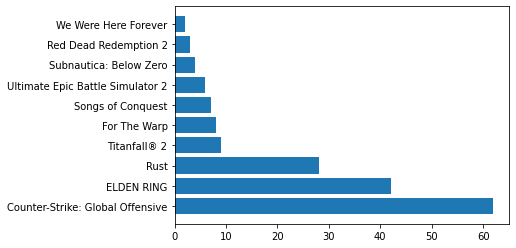

In [49]:
unique_games = false_preds.game_name.unique()
game_dist = false_preds.game_name.value_counts()
labels = game_dist.index.tolist()

print(game_dist)

plt.barh(range(0, len(unique_games)), width=game_dist.values, tick_label=labels)
plt.show()



In [50]:
from datetime import datetime

def get_date_object (date_string):
    date_time_obj = datetime.strptime(date_string, '%d %B, %Y')
    return date_time_obj

def get_year (date_object):
    return date_object.year

reviews['review_date_object'] = reviews.review_date.apply(get_date_object)
reviews['review_year'] = reviews.review_date_object.apply(get_year)

reviews

,Unnamed: 0,game_name,review_text,hours_played,rating,found_helpful,product_count,review_date,early_access,review_length,review_date_object,review_year
0,0,For The Warp,good game i feel the graphics vibe of into the...,10.9,1.0,0.0,127.0,"12 September, 2021",True,441,2021-09-12,2021
1,1,For The Warp,brilliant little game had so much fun with it ...,6.1,1.0,0.0,117.0,"19 July, 2021",True,109,2021-07-19,2021
2,2,For The Warp,solid deck building space exploration/combat a...,7.7,1.0,0.0,42.0,"22 January, 2021",True,63,2021-01-22,2021
3,3,For The Warp,often absolutely dependent on luck in the firs...,14.3,1.0,0.0,212.0,"05 April, 2020",True,277,2020-04-05,2020
4,4,For The Warp,a nice game which lacks some polish at the mom...,5.7,1.0,0.0,1289.0,"23 August, 2020",True,466,2020-08-23,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
3827,4909,Counter-Strike: Global Offensive,russian players makes the game bad,248.8,0.0,0.0,2.0,"17 May, 2022",False,34,2022-05-17,2022
3828,4910,Counter-Strike: Global Offensive,cant start it,17.7,0.0,0.0,31.0,"21 May, 2022",False,13,2022-05-21,2022
3829,4911,Counter-Strike: Global Offensive,10k minimum players in lowest ranks xd,79.6,0.0,0.0,37.0,"17 May, 2022",False,38,2022-05-17,2022
3830,4914,Counter-Strike: Global Offensive,when i open the game the game is black and i c...,166.9,0.0,0.0,44.0,"21 May, 2022",False,258,2022-05-21,2022


In [51]:
'''
ratings = reviews.groupby(['game_name', 'review_year']).rating.mean().unstack
ratings

reviews.groupby(by=[reviews.review_date_object.dt.year, reviews.review_date_object.dt.month, reviews.game_name]).mean()
'''

"\nratings = reviews.groupby(['game_name', 'review_year']).rating.mean().unstack\nratings\n\nreviews.groupby(by=[reviews.review_date_object.dt.year, reviews.review_date_object.dt.month, reviews.game_name]).mean()\n"

<AxesSubplot:xlabel='Average review length per game', ylabel='review lenght'>

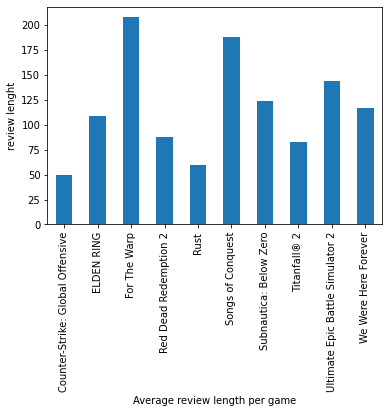

In [52]:
review_len = reviews.groupby(['game_name']).review_length.mean()
review_len.plot(kind='bar',  xlabel = 'Average review length per game', ylabel = 'review lenght')

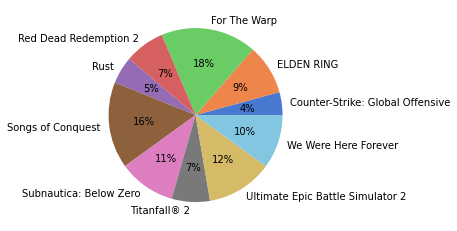

In [53]:
unique_games = reviews.game_name.unique()
colors = sns.color_palette('muted', n_colors=10, as_cmap=True)
labels = review_len.index.tolist()
plt.pie(review_len, labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

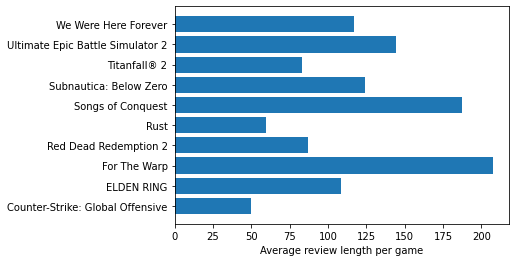

In [54]:
labels = review_len.index.tolist()
unique_games = reviews.game_name.unique()
plt.xlabel('Average review length per game')
plt.barh(range(0, len(unique_games)), width=review_len.values, tick_label=labels)
plt.show()

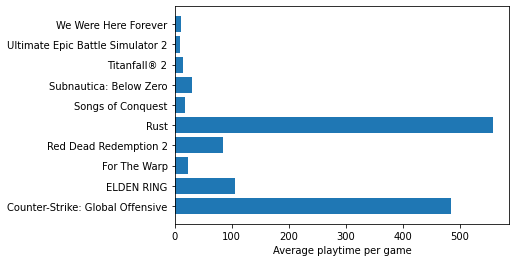

In [55]:
playtime = reviews.groupby(['game_name']).hours_played.mean()
unique_games = reviews.game_name.unique()
labels = playtime.index.tolist()
plt.xlabel('Average playtime per game')
plt.barh(range(0, len(unique_games)), width=playtime.values, tick_label=labels)
plt.show()

Text(0.5, 0, 'average rating')

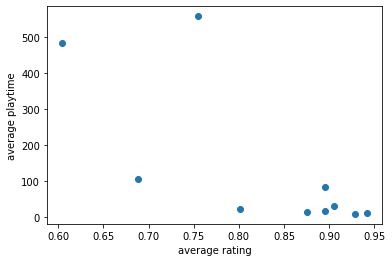

In [56]:
avg_rating = reviews.groupby(['game_name']).rating.mean()
plt.scatter(avg_rating, playtime)
plt.ylabel("average playtime")
plt.xlabel("average rating")

Text(0.5, 0, 'average rating')

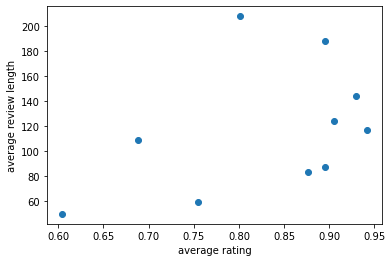

In [57]:
plt.scatter(avg_rating, review_len)
plt.ylabel("average review length")
plt.xlabel("average rating")

Text(0.5, 0, 'average review length')

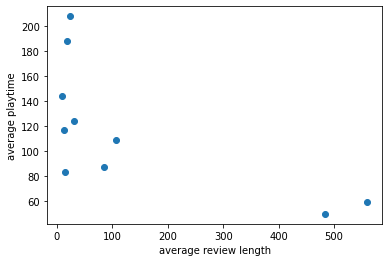

In [58]:
plt.scatter(playtime, review_len)
plt.ylabel("average playtime")
plt.xlabel("average review length")

Text(0, 0.5, 'found helpful')

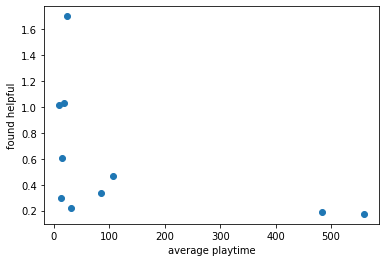

In [59]:
avg_helpfulness = reviews.groupby(['game_name']).found_helpful.mean()
plt.scatter(playtime, avg_helpfulness)
plt.xlabel("average playtime")
plt.ylabel("found helpful")

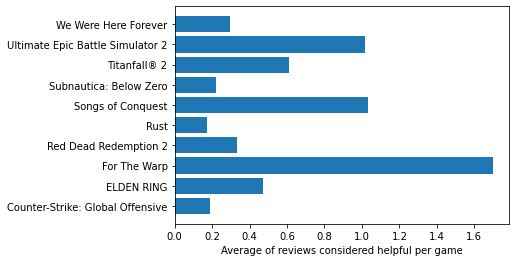

In [60]:
labels = avg_helpfulness.index.tolist()
unique_games = reviews.game_name.unique()
plt.xlabel('Average of reviews considered helpful per game')
plt.barh(range(0, len(unique_games)), width=avg_helpfulness.values, tick_label=labels)
plt.show()

<AxesSubplot:xlabel='Prediction compared with classification of reviews'>

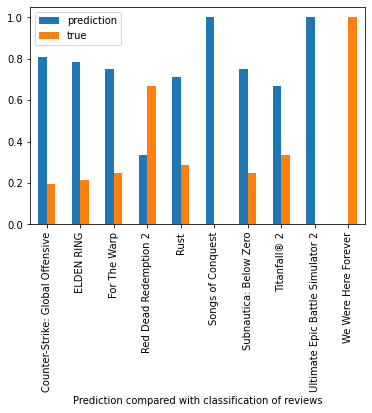

In [61]:
false_predicts = false_preds.groupby(['game_name']).mean()
false_predicts.plot(kind='bar', xlabel = 'Prediction compared with classification of reviews')

Text(0.5, 0, 'average rating')

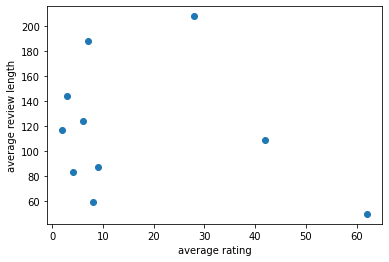

In [62]:
plt.scatter(false_preds.game_name.value_counts(), review_len)
plt.ylabel("average review length")
plt.xlabel("average rating")